In [1]:
# Trabajo practico
## intentaremos generar distintos modelos de aprendizaje de maquina que intenten predecir, basandose en locacion, dia del año y franja horaria la probabilidad de ocurrencia de un delito.


## Configuraciones e Imports

In [4]:

# =====================
# Configuración & Imports
# =====================
import os
import math
import json

import numpy as np
import pandas as pd

from datetime import datetime
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report
import xgboost as xgb
import seaborn as sns

## Data import

In [5]:
# =====================
# Import de Dataset
# =====================
DATA_DIR = r"/content/dataset"

# Detecta automáticamente todos los archivos .csv dentro de la carpeta
csv_files = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith(".csv")]
print(f"Se encontraron {len(csv_files)} archivos CSV.")

# Carga y concatena todos los CSV
df_list = []
for path in csv_files:
    try:
        df = pd.read_csv(path)
        df_list.append(df)
        print(f"✔️  {os.path.basename(path)} ({len(df)} filas)")
    except Exception as e:
        print(f"⚠️ Error con {os.path.basename(path)}: {e}")

df = pd.concat(df_list, ignore_index=True)
print("\nTotal filas combinadas:", len(df))

df.head()


Se encontraron 9 archivos CSV.
✔️  delitos_2020.csv (86175 filas)
✔️  delitos_2024.csv (158838 filas)
✔️  delitos_2019.csv (149524 filas)
✔️  delitos_2016.csv (154712 filas)
✔️  delitos_2023.csv (155897 filas)
✔️  delitos_2021.csv (111962 filas)
✔️  delitos_2018.csv (149455 filas)
✔️  delitos_2022.csv (140918 filas)
✔️  delitos_2017.csv (146938 filas)

Total filas combinadas: 1254419


,id-mapa,anio,mes,dia,fecha,franja,tipo,subtipo,uso_arma,uso_moto,barrio,comuna,latitud,longitud,cantidad
0,192085,2020,JUNIO,MIERCOLES,2020-06-10,20.0,Hurto,Hurto total,NO,NO,NaN,NaN,NaN,NaN,1
1,192086,2020,AGOSTO,VIERNES,2020-08-21,11.0,Hurto,Hurto total,NO,NO,PARQUE AVELLANEDA,9.0,-34.641905,-58.487037,1
2,192087,2020,SEPTIEMBRE,MARTES,2020-09-15,20.0,Hurto,Hurto total,NO,NO,PARQUE AVELLANEDA,9.0,-34.641899,-58.480738,1
3,192088,2020,SEPTIEMBRE,MARTES,2020-09-22,10.0,Robo,Robo total,SI,NO,PARQUE AVELLANEDA,9.0,-34.641043,-58.484628,1
4,192089,2020,OCTUBRE,MARTES,2020-10-06,10.0,Hurto,Hurto total,NO,NO,PARQUE AVELLANEDA,9.0,-34.641055,-58.484537,1


## Exploratory Data Analysis

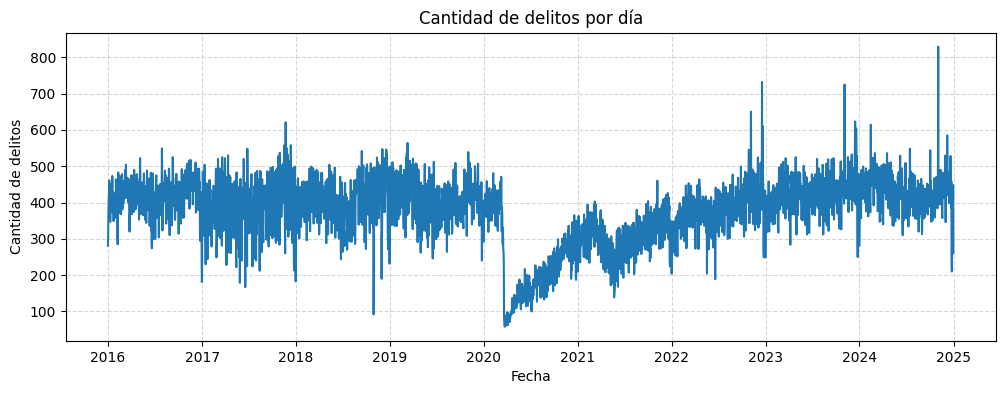

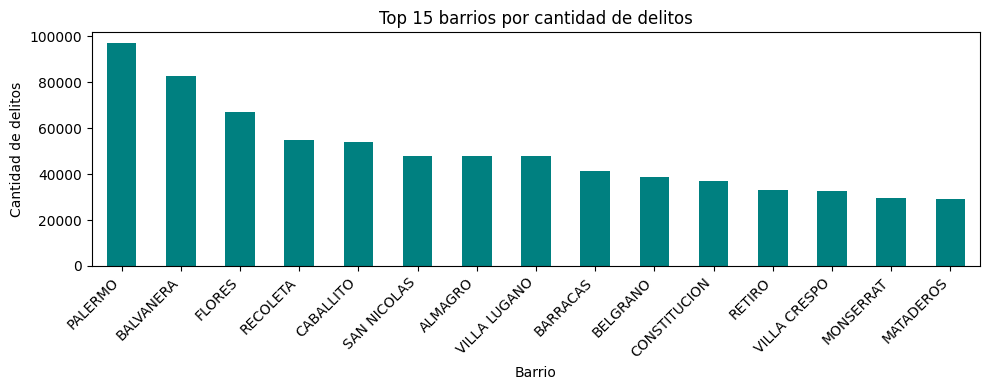

Se detectó columna de tipo de delito: tipo


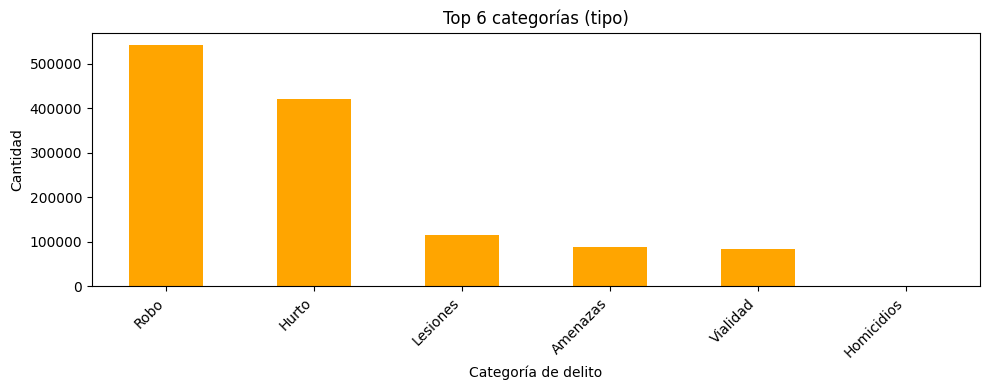

In [6]:
# Ajuste del dataset
# Aseguramos que la columna 'fecha' sea datetime
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

# Eliminamos filas con fecha vacía (por si hay alguna)
df = df.dropna(subset=['fecha'])


# Conteo de delitos por día
df['_date'] = df['fecha'].dt.date
counts_by_day = df.groupby('_date').size()

plt.figure(figsize=(12, 4))
counts_by_day.plot()
plt.title("Cantidad de delitos por día")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de delitos")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Top barrios
# Verificamos que exista una columna válida
if 'barrio' in df.columns:
    geo_col = 'barrio'
elif 'comuna' in df.columns:
    geo_col = 'comuna'
else:
    raise ValueError("No se encontró columna geográfica válida ('barrio' o 'comuna').")

top_geo = df[geo_col].value_counts().head(15)

plt.figure(figsize=(10, 4))
top_geo.plot(kind='bar', color='teal')
plt.title(f"Top {len(top_geo)} {geo_col}s por cantidad de delitos")
plt.xlabel(geo_col.capitalize())
plt.ylabel("Cantidad de delitos")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Tipo de delito
guess_type_cols = [c for c in df.columns if 'delito' in c or 'hecho' in c or 'tipo' in c]

if guess_type_cols:
    tipo_col = guess_type_cols[0]
    print(f"Se detectó columna de tipo de delito: {tipo_col}")
    top_tipo = df[tipo_col].value_counts().head(15)
    plt.figure(figsize=(10, 4))
    top_tipo.plot(kind='bar', color='orange')
    plt.title(f"Top {len(top_tipo)} categorías ({tipo_col})")
    plt.xlabel("Categoría de delito")
    plt.ylabel("Cantidad")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



In [7]:

# Estructura general

print("Dimensiones del dataset:", df.shape)
print("\nTipos de datos:")
print(df.dtypes)

# Nulos y valores únicos
print("\nCantidad de valores nulos por columna:")
print(df.isna().sum().sort_values(ascending=False))



Dimensiones del dataset: (1254419, 16)

Tipos de datos:
id-mapa              int64
anio                 int64
mes                 object
dia                 object
fecha       datetime64[ns]
franja             float64
tipo                object
subtipo             object
uso_arma            object
uso_moto            object
barrio              object
comuna             float64
latitud            float64
longitud           float64
cantidad             int64
_date               object
dtype: object

Cantidad de valores nulos por columna:
comuna      31983
barrio      31981
latitud     27721
longitud    27721
franja       2375
id-mapa         0
mes             0
anio            0
subtipo         0
tipo            0
fecha           0
dia             0
uso_arma        0
uso_moto        0
cantidad        0
_date           0
dtype: int64


In [8]:
print("\nCantidad de valores únicos por columna:")
print(df.nunique().sort_values(ascending=False))

# Porcentaje de nulos
null_percent = df.isna().mean().sort_values(ascending=False) * 100
print("\nPorcentaje de nulos (%):")
print(null_percent)


Cantidad de valores únicos por columna:
id-mapa     1254419
longitud     315976
latitud      295783
fecha          3288
_date          3288
barrio           48
franja           24
comuna           15
mes              12
subtipo          10
anio              9
dia               7
tipo              6
uso_moto          2
uso_arma          2
cantidad          1
dtype: int64

Porcentaje de nulos (%):
comuna      2.549627
barrio      2.549467
latitud     2.209868
longitud    2.209868
franja      0.189331
id-mapa     0.000000
mes         0.000000
anio        0.000000
subtipo     0.000000
tipo        0.000000
fecha       0.000000
dia         0.000000
uso_arma    0.000000
uso_moto    0.000000
cantidad    0.000000
_date       0.000000
dtype: float64


In [9]:
# Vemos poco impacto porcentual en el dataset. Continuamos con la remoción de los nulos
print("shape df original:", df.shape)
print("shape sin NaNs:", df.dropna().shape)

df.dropna(inplace=True)

shape df original: (1254419, 16)
shape sin NaNs: (1220378, 16)


In [10]:
df.head(5)

,id-mapa,anio,mes,dia,fecha,franja,tipo,subtipo,uso_arma,uso_moto,barrio,comuna,latitud,longitud,cantidad,_date
1,192086,2020,AGOSTO,VIERNES,2020-08-21,11.0,Hurto,Hurto total,NO,NO,PARQUE AVELLANEDA,9.0,-34.641905,-58.487037,1,2020-08-21
2,192087,2020,SEPTIEMBRE,MARTES,2020-09-15,20.0,Hurto,Hurto total,NO,NO,PARQUE AVELLANEDA,9.0,-34.641899,-58.480738,1,2020-09-15
3,192088,2020,SEPTIEMBRE,MARTES,2020-09-22,10.0,Robo,Robo total,SI,NO,PARQUE AVELLANEDA,9.0,-34.641043,-58.484628,1,2020-09-22
4,192089,2020,OCTUBRE,MARTES,2020-10-06,10.0,Hurto,Hurto total,NO,NO,PARQUE AVELLANEDA,9.0,-34.641055,-58.484537,1,2020-10-06
5,192090,2020,OCTUBRE,SABADO,2020-10-31,10.0,Robo,Robo total,NO,NO,PARQUE AVELLANEDA,9.0,-34.641899,-58.480738,1,2020-10-31


In [11]:
# Dropeamos id-mapa, _date, comuna (vamos a usar barrio), año (solo usamos dia, mes y numero de dia)
df.drop(columns=['id-mapa', '_date', 'comuna', 'anio'], inplace=True, errors='ignore')
df.head(5)

,mes,dia,fecha,franja,tipo,subtipo,uso_arma,uso_moto,barrio,latitud,longitud,cantidad
1,AGOSTO,VIERNES,2020-08-21,11.0,Hurto,Hurto total,NO,NO,PARQUE AVELLANEDA,-34.641905,-58.487037,1
2,SEPTIEMBRE,MARTES,2020-09-15,20.0,Hurto,Hurto total,NO,NO,PARQUE AVELLANEDA,-34.641899,-58.480738,1
3,SEPTIEMBRE,MARTES,2020-09-22,10.0,Robo,Robo total,SI,NO,PARQUE AVELLANEDA,-34.641043,-58.484628,1
4,OCTUBRE,MARTES,2020-10-06,10.0,Hurto,Hurto total,NO,NO,PARQUE AVELLANEDA,-34.641055,-58.484537,1
5,OCTUBRE,SABADO,2020-10-31,10.0,Robo,Robo total,NO,NO,PARQUE AVELLANEDA,-34.641899,-58.480738,1


In [12]:
# Convertir fecha a día del mes,
df['dia_num'] = df['fecha'].dt.day
df.drop(columns=['fecha'], errors='ignore')
df.head(5)

,mes,dia,fecha,franja,tipo,subtipo,uso_arma,uso_moto,barrio,latitud,longitud,cantidad,dia_num
1,AGOSTO,VIERNES,2020-08-21,11.0,Hurto,Hurto total,NO,NO,PARQUE AVELLANEDA,-34.641905,-58.487037,1,21
2,SEPTIEMBRE,MARTES,2020-09-15,20.0,Hurto,Hurto total,NO,NO,PARQUE AVELLANEDA,-34.641899,-58.480738,1,15
3,SEPTIEMBRE,MARTES,2020-09-22,10.0,Robo,Robo total,SI,NO,PARQUE AVELLANEDA,-34.641043,-58.484628,1,22
4,OCTUBRE,MARTES,2020-10-06,10.0,Hurto,Hurto total,NO,NO,PARQUE AVELLANEDA,-34.641055,-58.484537,1,6
5,OCTUBRE,SABADO,2020-10-31,10.0,Robo,Robo total,NO,NO,PARQUE AVELLANEDA,-34.641899,-58.480738,1,31


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


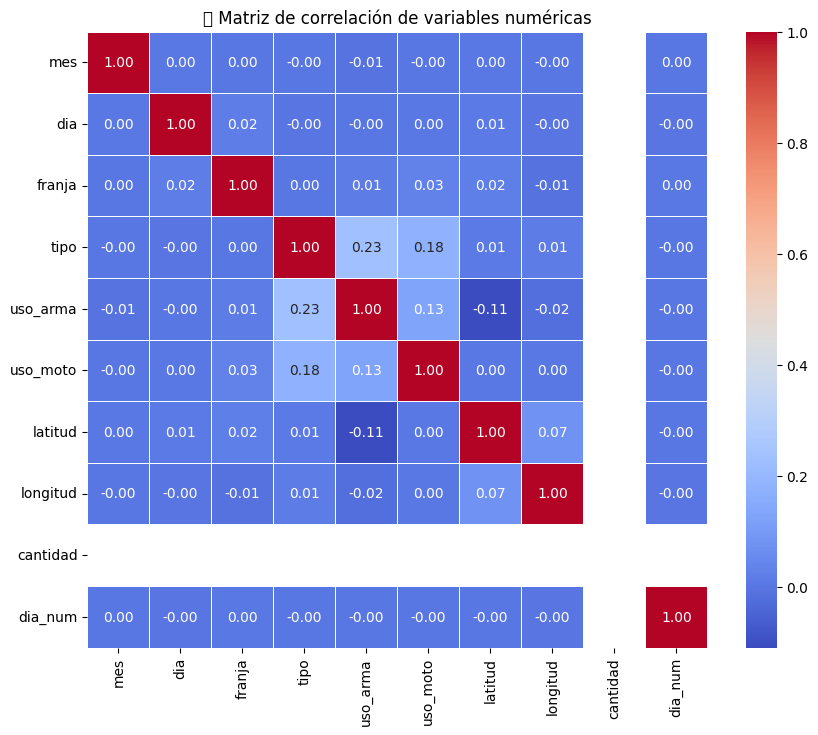

In [13]:
# Convertimos variables categóricas relevantes a numéricas
df_corr = df.copy()

# Encode simple para variables categóricas
for col in ['dia', 'mes', 'uso_arma', 'uso_moto', 'tipo']:
    df_corr[col] = df_corr[col].astype('category').cat.codes

# Calculamos matriz de correlación
corr = df_corr.corr(numeric_only=True)

# Graficamos el mapa de calor
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("📊 Matriz de correlación de variables numéricas")
plt.show()


Las variables mas correlacionadas parecen ser tipo con uso_arma, y uso_moto con tipo (0.23 y 0.18 respectivamente). Proseguimos con las variables seleccionadas.

Para poder generar predicciones, debo generar bins de longitud, latitud y agruparlos por dia, dia_num, mes, franja. Para que luego se pueda trabajar la regresion.

In [14]:
# Definimos el tamaño de cada celda (ajustable)
lat_bin_size = 0.5
lon_bin_size = 0.5

# Creamos columnas de bin espacial
df['lat_bin'] = (df['latitud'] // lat_bin_size) * lat_bin_size
df['lon_bin'] = (df['longitud'] // lon_bin_size) * lon_bin_size


In [15]:
df_grouped = (
    df.groupby(['dia', 'dia_num', 'mes', 'franja', 'lat_bin', 'lon_bin'])
      .agg({'cantidad':'sum'})
      .reset_index()
)

df_grouped.sort_values('cantidad', ascending=False).head(5)


,dia,dia_num,mes,franja,lat_bin,lon_bin,cantidad
65164,SABADO,2,NOVIEMBRE,0.0,-35.0,-58.5,308
26044,LUNES,2,DICIEMBRE,0.0,-35.0,-58.5,284
80,DOMINGO,1,DICIEMBRE,0.0,-35.0,-58.5,283
67036,SABADO,7,DICIEMBRE,0.0,-35.0,-58.5,267
80569,VIERNES,8,NOVIEMBRE,0.0,-35.0,-58.5,266


In [16]:
df_grouped.shape

(90221, 7)

RMSE: 11.044
MAE:  7.605
R²:   0.436


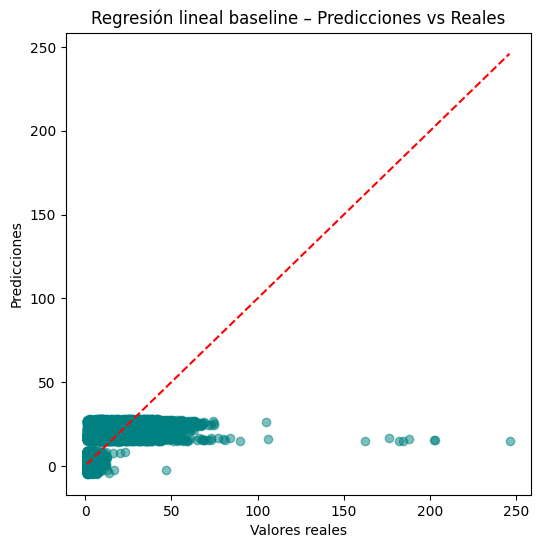

In [17]:
# Convertimos variables categóricas simples en códigos numéricos
for col in ['dia', 'mes']:
    df_grouped[col] = df_grouped[col].astype('category').cat.codes

X = df_grouped[['lat_bin', 'lon_bin', 'dia_num', 'franja', 'dia', 'mes']]
y = df_grouped['cantidad']

# =========================
# 4️⃣ Train-test split + escalado
# =========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =========================
# 5️⃣ Modelo baseline: Regresión Lineal
# =========================
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# =========================
# 6️⃣ Evaluación
# =========================
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")
print(f"R²:   {r2:.3f}")

# =========================
# 7️⃣ Visualización
# =========================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Regresión lineal baseline – Predicciones vs Reales")
plt.show()

Random Forest -> RMSE: 10.365
                  MAE:  6.451
                  R²:   0.503


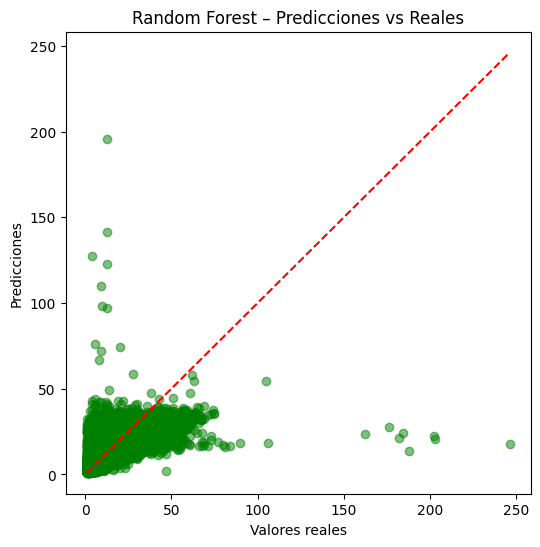

In [18]:
# =========================
# 6.3 Modelo Random Forest
# =========================
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Entrenamiento
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluación
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest -> RMSE: {rmse_rf:.3f}")
print(f"                  MAE:  {mae_rf:.3f}")
print(f"                  R²:   {r2_rf:.3f}")

# Visualización
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Random Forest – Predicciones vs Reales")
plt.show()


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:14:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost -> RMSE: 8.066
            MAE:  4.914
            R²:   0.699


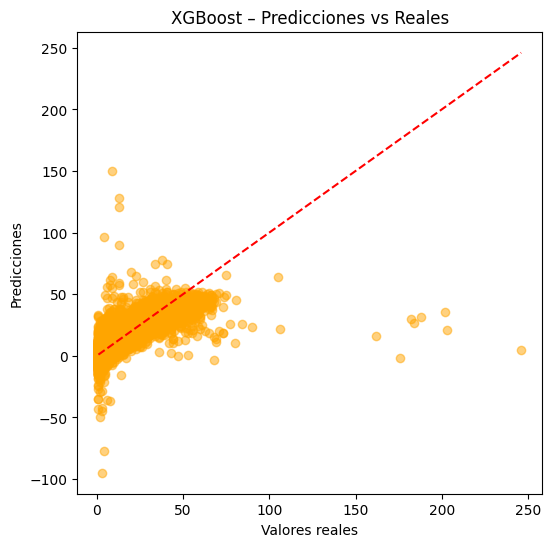

In [22]:
# =========================
# 6.4 Modelo XGBoost
# =========================
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Entrenamiento
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=15,
    subsample=0.8,
    colsample_bytree=0.8,
    device = "cuda",   # usa GPU si está disponible
    predictor='gpu_predictor',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# Predicciones
y_pred_xgb = xgb_model.predict(X_test)

# Evaluación
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost -> RMSE: {rmse_xgb:.3f}")
print(f"            MAE:  {mae_xgb:.3f}")
print(f"            R²:   {r2_xgb:.3f}")

# Visualización
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("XGBoost – Predicciones vs Reales")
plt.show()


In [20]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint, uniform
import numpy as np

# ==========================
# Configuración base GPU
# ==========================
xgb = XGBRegressor(
    device= 'cuda',       # usa GPU CUDA
    predictor='gpu_predictor',     # también en predicción
    random_state=42,
    n_jobs=-1,
    eval_metric='rmse',
    verbosity=1
)

# ==========================
# Espacio de búsqueda
# ==========================
param_dist = {
    'n_estimators': randint(400, 1000),
    'learning_rate': uniform(0.01, 0.15),
    'max_depth': randint(4, 12),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 1),
    'min_child_weight': randint(1, 8)
}

# ==========================
# Randomized Search
# ==========================
random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=25,              # más iteraciones = mejor ajuste
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("⏳ Entrenando búsqueda aleatoria en GPU...")
random_search.fit(X_train, y_train)

# ==========================
# Evaluación final
# ==========================
print("\n✅ Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

best_xgb = random_search.best_estimator_

y_pred = best_xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 Resultados finales:")
print(f"XGBoost Tuned (GPU) -> RMSE: {rmse:.3f}")
print(f"                        MAE:  {mae:.3f}")
print(f"                        R²:   {r2:.3f}")


⏳ Entrenando búsqueda aleatoria en GPU...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:14:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Mejores hiperparámetros encontrados:
{'colsample_bytree': np.float64(0.9757995766256756), 'gamma': np.float64(0.8948273504276488), 'learning_rate': np.float64(0.09968499682166276), 'max_depth': 11, 'min_child_weight': 7, 'n_estimators': 855, 'subsample': np.float64(0.8281775897621597)}

📊 Resultados finales:
XGBoost Tuned (GPU) -> RMSE: 7.818
                        MAE:  4.204
                        R²:   0.717


In [24]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuramos el mejor modelo para entrenamiento final en GPU
best_xgb.set_params(
    n_estimators=1200,
    tree_method='hist',
    device='cuda',                 # asegura uso de GPU
    eval_metric='rmse',            # ← ahora va en el estimador
    early_stopping_rounds=50,      # ← también en el estimador
    verbosity=1
)

print("🚀 Entrenando modelo final (GPU) con early stopping...")

# En XGBoost 2.x, 'eval_set' sí va en fit(); 'eval_metric' y 'early_stopping_rounds' NO.
best_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=50
)

# Evaluación
y_pred = best_xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 Resultados finales:")
print(f"XGBoost Tuned (GPU) -> RMSE: {rmse:.3f}")
print(f"                        MAE:  {mae:.3f}")
print(f"                        R²:   {r2:.3f}")


🚀 Entrenando modelo final (GPU) con early stopping...
[0]	validation_0-rmse:13.96052


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [08:16:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()


[50]	validation_0-rmse:9.69387
[100]	validation_0-rmse:8.74810
[150]	validation_0-rmse:8.19833
[200]	validation_0-rmse:8.01105
[250]	validation_0-rmse:7.84185
[300]	validation_0-rmse:7.72397
[350]	validation_0-rmse:7.72682
[372]	validation_0-rmse:7.74034

📊 Resultados finales:
XGBoost Tuned (GPU) -> RMSE: 7.711
                        MAE:  4.238
                        R²:   0.725
